### ROC кривые для BERT модификаций

In [1]:
import tensorflow as tf
import os
import numpy as np
import random
from sklearn.metrics import roc_auc_score

SEED = 42

In [2]:
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [3]:
def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

In [4]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import transformers
import sentencepiece
import re
import nltk
import pandas as pd
from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.metrics import auc
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from transformers import BertTokenizer
from sklearn.metrics import roc_curve, confusion_matrix,auc, accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
news_data = pd.read_csv('/content/drive/MyDrive/Data/NewsAgreggatorKaggleFNforBERT.csv')
news_data.head()

,title,label
0,supply demand chain executive oil falls to aro...,0
1,london south east major averages climb off low...,0
2,gabrielle cintorino new poll shows support for...,1
3,artist s impression of the clinton machine rus...,1
4,worcester telegram s p gains on global growth ...,0


In [9]:
print(news_data['title'])

0        supply demand chain executive oil falls to aro...
1        london south east major averages climb off low...
2        gabrielle cintorino new poll shows support for...
3        artist s impression of the clinton machine rus...
4        worcester telegram s p gains on global growth ...
                               ...                        
24633    qfinance com global markets world stocks coppe...
24634    david gutierrez staff writer why hydrogen pero...
24635    bay news spacex preps falcon rocket for pre da...
24636    law subscription jos a bank men s wearhouse in...
24637    hillary clinton laundered isis cash says inves...
Name: title, Length: 24638, dtype: object


In [10]:
news_data.isnull().sum()

title    180
label      0
dtype: int64

In [11]:
news_data = news_data.dropna()

In [12]:
news_data.isnull().sum()

title    0
label    0
dtype: int64

In [13]:
#separating the data and label
X = news_data['title'].values
Y = news_data['label'].values

In [14]:
print(X)

['supply demand chain executive oil falls to around after china japan data'
 'london south east major averages climb off lows but remain in the red'
 'gabrielle cintorino new poll shows support for police officers is on the rise cop haters will be furious'
 ... 'bay news spacex preps falcon rocket for pre dawn launch sunday'
 'law subscription jos a bank men s wearhouse ink b merger deal'
 'hillary clinton laundered isis cash says investigating u s army officer']


In [15]:
print(Y)

[0 0 1 ... 0 0 1]


In [16]:
EPOCHS=2
max_seq_length = 60
LEARNING_RATE=1e-5
early_stopping=early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [17]:
def bert_encode(data, max_len) :
    input_ids = [] 
    attention_masks = []
    
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(data[i],
                                        add_special_tokens=True,
                                        max_length=max_len,
                                        pad_to_max_length=True,
                                        return_attention_mask=True)
        
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=2)

train_input_ids, train_attention_masks = bert_encode(X_train, 60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [21]:
def roc_curve_plot(fpr,tpr,roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' %roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('BERT')
    plt.legend(loc="lower right")
    plt.show()

In [22]:
METRICS = [
  tf.keras.metrics.TruePositives(name='tp'),
  tf.keras.metrics.FalsePositives(name='fp'),
  tf.keras.metrics.TrueNegatives(name='tn'),
  tf.keras.metrics.FalseNegatives(name='fn'), 
  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
  tf.keras.metrics.AUC(name='auc')]

In [23]:
import keras
from keras.models import load_model

### BERT

#### Fine-tuned Model

In [24]:
from transformers import TFBertModel

In [25]:
model = load_model('/content/drive/MyDrive/Models/FINAL (BERT, DISTILBERT)/BERT.h5', custom_objects={"TFBertModel": TFBertModel})

In [26]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 60)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                            

In [27]:
test_input_ids, test_attention_masks = bert_encode(X_test, 60)

In [28]:
score = model.evaluate([test_input_ids, test_attention_masks], Y_test, verbose=1) 

153/153 [==============================] - 26s 134ms/step - loss: 0.0809 - tp: 2310.0000 - fp: 12.0000 - tn: 2452.0000 - fn: 118.0000 - accuracy: 0.9734 - precision: 0.9948 - recall: 0.9514 - auc: 0.9960


In [29]:
print(f'BERT accuracy: {score[5]}')

BERT accuracy: 0.9734259843826294


In [30]:
BERT_predict=model.predict([test_input_ids, test_attention_masks], verbose=1)

153/153 [==============================] - 24s 133ms/step


In [31]:
# np.save('/content/drive/MyDrive/Predict/BERT_predict.npy', BERT_predict)

**Testing**

In [32]:
news_test = pd.read_csv('/content/drive/MyDrive/Data/FNDatasetBERT.csv')

In [33]:
x_test = news_test['title'].values
y_test = news_test['label'].values

In [34]:
test_input_ids, test_attention_masks = bert_encode(x_test, 60)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [35]:
score = model.evaluate([test_input_ids, test_attention_masks], y_test, verbose=1) 

1404/1404 [==============================] - 190s 135ms/step - loss: 0.5045 - tp: 21303.0000 - fp: 4028.0000 - tn: 17389.0000 - fn: 2178.0000 - accuracy: 0.8618 - precision: 0.8410 - recall: 0.9072 - auc: 0.9264


In [36]:
print(f'BERT accuracy FNDataset: {score[5]}')

BERT accuracy FNDataset: 0.8617755770683289


In [37]:
BERT_test_predict=model.predict([test_input_ids, test_attention_masks], verbose=1)

1404/1404 [==============================] - 186s 132ms/step


In [38]:
# np.save('/content/drive/MyDrive/Predict/BERT_test_predict.npy', BERT_test_predict)

#### Trained Classifier

In [39]:
model = load_model('/content/drive/MyDrive/Models/FINAL (BERT, DISTILBERT)/BERT_freezed.h5', custom_objects={"TFBertModel": TFBertModel})

In [40]:
test_input_ids, test_attention_masks = bert_encode(X_test, 60)

In [41]:
score = model.evaluate([test_input_ids, test_attention_masks], Y_test, verbose=1) 

153/153 [==============================] - 24s 136ms/step - loss: 0.0512 - tp: 2366.0000 - fp: 21.0000 - tn: 2443.0000 - fn: 62.0000 - accuracy: 0.9830 - precision: 0.9912 - recall: 0.9745 - auc: 0.9984


In [42]:
print(f'BERT accuracy: {score[5]}')

BERT accuracy: 0.9830335378646851


In [43]:
BERT_freezed_predict=model.predict([test_input_ids, test_attention_masks], verbose=1)

153/153 [==============================] - 23s 134ms/step


In [44]:
# np.save('/content/drive/MyDrive/Predict/BERT_freezed_predict.npy', BERT_freezed_predict)

**Testing**

In [45]:
test_input_ids, test_attention_masks = bert_encode(x_test, 60)

In [46]:
score = model.evaluate([test_input_ids, test_attention_masks], y_test, verbose=1) 

1404/1404 [==============================] - 190s 135ms/step - loss: 0.5317 - tp: 22580.0000 - fp: 5688.0000 - tn: 15729.0000 - fn: 901.0000 - accuracy: 0.8532 - precision: 0.7988 - recall: 0.9616 - auc: 0.9407


In [47]:
print(f'BERT accuracy FNDataset: {score[5]}')

BERT accuracy FNDataset: 0.8532451391220093


In [48]:
BERT_freezed_test_predict=model.predict([test_input_ids, test_attention_masks], verbose=1)

1404/1404 [==============================] - 186s 132ms/step


In [49]:
# np.save('/content/drive/MyDrive/Predict/BERT_freezed_test_predict.npy', BERT_freezed_test_predict)

### DistilBERT

#### Fine-tuned Model

In [50]:
from transformers import DistilBertTokenizer

In [51]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [52]:
from transformers import TFDistilBertModel

In [53]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=2)

train_input_ids, train_attention_masks = bert_encode(X_train, 60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [54]:
model = load_model('/content/drive/MyDrive/Models/FINAL (BERT, DISTILBERT)/DISTILBERT.h5', custom_objects={"TFDistilBertModel": TFDistilBertModel})

In [55]:
test_input_ids, test_attention_masks = bert_encode(X_test, 60)

In [56]:
score = model.evaluate([test_input_ids, test_attention_masks], Y_test, verbose=1) 

153/153 [==============================] - 13s 68ms/step - loss: 0.0588 - tp: 2367.0000 - fp: 23.0000 - tn: 2441.0000 - fn: 61.0000 - accuracy: 0.9828 - precision: 0.9904 - recall: 0.9749 - auc: 0.9972


In [57]:
print(f'DistilBERT accuracy: {score[5]}')

DistilBERT accuracy: 0.9828290939331055


In [58]:
DistilBERT_predict=model.predict([test_input_ids, test_attention_masks], verbose=1)

153/153 [==============================] - 12s 67ms/step


In [59]:
# np.save('/content/drive/MyDrive/Predict/DistilBERT_predict.npy', DistilBERT_predict)

**Testing**

In [60]:
test_input_ids, test_attention_masks = bert_encode(x_test, 60)

In [61]:
score = model.evaluate([test_input_ids, test_attention_masks], y_test, verbose=1) 

1404/1404 [==============================] - 99s 70ms/step - loss: 0.5937 - tp: 22246.0000 - fp: 4873.0000 - tn: 16544.0000 - fn: 1235.0000 - accuracy: 0.8640 - precision: 0.8203 - recall: 0.9474 - auc: 0.9240


In [62]:
print(f'DistilBERT accuracy FNDataset: {score[5]}')

DistilBERT accuracy FNDataset: 0.8639582991600037


In [63]:
DistilBERT_test_predict=model.predict([test_input_ids, test_attention_masks], verbose=1)

1404/1404 [==============================] - 93s 67ms/step


In [64]:
# np.save('/content/drive/MyDrive/Predict/DistilBERT_test_predict.npy', DistilBERT_test_predict)

#### Trained Classifier

In [65]:
model = load_model('/content/drive/MyDrive/Models/FINAL (BERT, DISTILBERT)/DISTILBERT_freezed.h5', custom_objects={"TFDistilBertModel": TFDistilBertModel})

In [66]:
test_input_ids, test_attention_masks = bert_encode(X_test, 60)

In [67]:
score = model.evaluate([test_input_ids, test_attention_masks], Y_test, verbose=1) 

153/153 [==============================] - 13s 68ms/step - loss: 0.0527 - tp: 2378.0000 - fp: 34.0000 - tn: 2430.0000 - fn: 50.0000 - accuracy: 0.9828 - precision: 0.9859 - recall: 0.9794 - auc: 0.9972


In [68]:
print(f'DistilBERT accuracy: {score[5]}')

DistilBERT accuracy: 0.9828290939331055


In [69]:
DistilBERT_freezed_predict=model.predict([test_input_ids, test_attention_masks], verbose=1)

153/153 [==============================] - 12s 67ms/step


In [70]:
# np.save('/content/drive/MyDrive/Predict/DistilBERT_freezed_predict.npy', DistilBERT_freezed_predict)

**Testing**

In [71]:
test_input_ids, test_attention_masks = bert_encode(x_test, 60)

In [72]:
score = model.evaluate([test_input_ids, test_attention_masks], y_test, verbose=1) 

1404/1404 [==============================] - 98s 70ms/step - loss: 0.6945 - tp: 22652.0000 - fp: 5822.0000 - tn: 15595.0000 - fn: 829.0000 - accuracy: 0.8519 - precision: 0.7955 - recall: 0.9647 - auc: 0.9178


In [73]:
print(f'DistilBERT accuracy FNDataset: {score[5]}')

DistilBERT accuracy FNDataset: 0.851864218711853


In [74]:
DistilBERT_freezed_test_predict=model.predict([test_input_ids, test_attention_masks], verbose=1)

1404/1404 [==============================] - 93s 66ms/step


In [75]:
# np.save('/content/drive/MyDrive/Predict/DistilBERT_freezed_test_predict.npy', DistilBERT_freezed_test_predict)

### RoBERTa

#### Fine-tuned Model

In [76]:
from transformers import RobertaTokenizer

In [77]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [78]:
from transformers import TFRobertaModel

In [79]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=2)

train_input_ids, train_attention_masks = bert_encode(X_train, 60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [80]:
model = load_model('/content/drive/MyDrive/Models/ROBERTA.h5', custom_objects={"TFRobertaModel": TFRobertaModel})

In [81]:
test_input_ids, test_attention_masks = bert_encode(X_test, 60)

In [82]:
score = model.evaluate([test_input_ids, test_attention_masks], Y_test, verbose=1) 

153/153 [==============================] - 23s 131ms/step - loss: 0.0528 - tp: 2396.0000 - fp: 49.0000 - tn: 2415.0000 - fn: 32.0000 - accuracy: 0.9834 - precision: 0.9800 - recall: 0.9868 - auc: 0.9972


In [83]:
print(f'RoBERTa accuracy: {score[5]}')

RoBERTa accuracy: 0.9834423661231995


In [84]:
RoBERTa_predict=model.predict([test_input_ids, test_attention_masks], verbose=1)

153/153 [==============================] - 24s 130ms/step


In [85]:
# np.save('/content/drive/MyDrive/Predict/RoBERTa_predict.npy', RoBERTa_predict)

**Testing**

In [86]:
test_input_ids, test_attention_masks = bert_encode(x_test, 60)

In [87]:
score = model.evaluate([test_input_ids, test_attention_masks], y_test, verbose=1) 

1404/1404 [==============================] - 185s 132ms/step - loss: 1.3897 - tp: 22941.0000 - fp: 12457.0000 - tn: 8960.0000 - fn: 540.0000 - accuracy: 0.7105 - precision: 0.6481 - recall: 0.9770 - auc: 0.8452


In [88]:
print(f'RoBERTa accuracy FNDataset: {score[5]}')

RoBERTa accuracy FNDataset: 0.7105216383934021


In [89]:
RoBERTa_test_predict=model.predict([test_input_ids, test_attention_masks], verbose=1)

1404/1404 [==============================] - 181s 129ms/step


In [90]:
# np.save('/content/drive/MyDrive/Predict/RoBERTa_test_predict.npy', RoBERTa_test_predict)

#### Trained Classifier

In [91]:
model = load_model('/content/drive/MyDrive/Models/ROBERTA_freezed_2.h5', custom_objects={"TFRobertaModel": TFRobertaModel})

In [92]:
test_input_ids, test_attention_masks = bert_encode(X_test, 60)

In [93]:
score = model.evaluate([test_input_ids, test_attention_masks], Y_test, verbose=1) 

153/153 [==============================] - 23s 131ms/step - loss: 0.0615 - tp: 2403.0000 - fp: 81.0000 - tn: 2383.0000 - fn: 25.0000 - accuracy: 0.9783 - precision: 0.9674 - recall: 0.9897 - auc: 0.9972


In [94]:
print(f'RoBERTa accuracy: {score[5]}')

RoBERTa accuracy: 0.978331983089447


In [95]:
RoBERTa_freezed_predict=model.predict([test_input_ids, test_attention_masks], verbose=1)

153/153 [==============================] - 24s 130ms/step


In [96]:
# np.save('/content/drive/MyDrive/Predict/RoBERTa_freezed_predict.npy', RoBERTa_freezed_predict)

**Testing**

In [97]:
test_input_ids, test_attention_masks = bert_encode(x_test, 60)

In [98]:
score = model.evaluate([test_input_ids, test_attention_masks], y_test, verbose=1) 

1404/1404 [==============================] - 186s 132ms/step - loss: 1.1422 - tp: 23161.0000 - fp: 11399.0000 - tn: 10018.0000 - fn: 320.0000 - accuracy: 0.7390 - precision: 0.6702 - recall: 0.9864 - auc: 0.8789


In [99]:
print(f'RoBERTa accuracy FNDataset: {score[5]}')

RoBERTa accuracy FNDataset: 0.7389861345291138


In [100]:
RoBERTa_freezed_test_predict=model.predict([test_input_ids, test_attention_masks], verbose=1)

1404/1404 [==============================] - 181s 129ms/step


In [101]:
# np.save('/content/drive/MyDrive/Predict/RoBERTa_freezed_test_predict.npy', RoBERTa_freezed_test_predict)

### ALBERT

#### Fine-tuned Model

In [102]:
from transformers import AlbertTokenizer

In [103]:
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

In [104]:
from transformers import TFAlbertModel

In [105]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=2)

train_input_ids, train_attention_masks = bert_encode(X_train, 60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [106]:
model = load_model('/content/drive/MyDrive/Models/ALBERT.h5', custom_objects={"TFAlbertModel": TFAlbertModel})

In [107]:
test_input_ids, test_attention_masks = bert_encode(X_test, 60)

In [108]:
score = model.evaluate([test_input_ids, test_attention_masks], Y_test, verbose=1) 

153/153 [==============================] - 25s 142ms/step - loss: 0.0682 - tp: 2396.0000 - fp: 85.0000 - tn: 2379.0000 - fn: 32.0000 - accuracy: 0.9761 - precision: 0.9657 - recall: 0.9868 - auc: 0.9966


In [109]:
print(f'ALBERT accuracy: {score[5]}')

ALBERT accuracy: 0.9760833978652954


In [110]:
ALBERT_predict=model.predict([test_input_ids, test_attention_masks], verbose=1)

153/153 [==============================] - 26s 143ms/step


In [111]:
# np.save('/content/drive/MyDrive/Predict/ALBERT_predict.npy', ALBERT_predict)

**Testing**

In [112]:
test_input_ids, test_attention_masks = bert_encode(x_test, 60)

In [113]:
score = model.evaluate([test_input_ids, test_attention_masks], y_test, verbose=1) 

1404/1404 [==============================] - 201s 143ms/step - loss: 0.8737 - tp: 22788.0000 - fp: 8668.0000 - tn: 12749.0000 - fn: 693.0000 - accuracy: 0.7915 - precision: 0.7244 - recall: 0.9705 - auc: 0.8842


In [114]:
print(f'ALBERT accuracy FNDataset: {score[5]}')

ALBERT accuracy FNDataset: 0.7915052175521851


In [115]:
ALBERT_test_predict=model.predict([test_input_ids, test_attention_masks], verbose=1)

1404/1404 [==============================] - 196s 140ms/step


In [116]:
# np.save('/content/drive/MyDrive/Predict/ALBERT_test_predict.npy', ALBERT_test_predict)

#### Trained Classifier


In [117]:
model = load_model('/content/drive/MyDrive/Models/ALBERT_freezed.h5', custom_objects={"TFAlbertModel": TFAlbertModel})

In [118]:
test_input_ids, test_attention_masks = bert_encode(X_test, 60)

In [119]:
score = model.evaluate([test_input_ids, test_attention_masks], Y_test, verbose=1) 

153/153 [==============================] - 25s 142ms/step - loss: 0.0693 - tp: 2364.0000 - fp: 60.0000 - tn: 2404.0000 - fn: 64.0000 - accuracy: 0.9747 - precision: 0.9752 - recall: 0.9736 - auc: 0.9968


In [120]:
print(f'ALBERT accuracy: {score[5]}')

ALBERT accuracy: 0.9746524691581726


In [121]:
ALBERT_freezed_predict=model.predict([test_input_ids, test_attention_masks], verbose=1)

153/153 [==============================] - 24s 142ms/step


In [122]:
# np.save('/content/drive/MyDrive/Predict/ALBERT_freezed_predict.npy', ALBERT_freezed_predict)

**Testing**

In [123]:
test_input_ids, test_attention_masks = bert_encode(x_test, 60)

In [124]:
score = model.evaluate([test_input_ids, test_attention_masks], y_test, verbose=1) 

1404/1404 [==============================] - 201s 143ms/step - loss: 0.5902 - tp: 22721.0000 - fp: 8810.0000 - tn: 12607.0000 - fn: 760.0000 - accuracy: 0.7869 - precision: 0.7206 - recall: 0.9676 - auc: 0.9421


In [125]:
print(f'ALBERT accuracy FNDataset: {score[5]}')

ALBERT accuracy FNDataset: 0.7868502140045166


In [126]:
ALBERT_freezed_test_predict=model.predict([test_input_ids, test_attention_masks], verbose=1)

1404/1404 [==============================] - 197s 140ms/step


In [127]:
# np.save('/content/drive/MyDrive/Predict/ALBERT_freezed_test_predict.npy', ALBERT_freezed_test_predict)

In [128]:
BERT_roc_auc = roc_auc_score(Y_test, BERT_predict)
BERT_freezed_roc_auc = roc_auc_score(Y_test, BERT_freezed_predict)
DistilBERT_roc_auc = roc_auc_score(Y_test, DistilBERT_predict)
DistilBERT_freezed_roc_auc = roc_auc_score(Y_test, DistilBERT_freezed_predict)
RoBERTa_roc_auc = roc_auc_score(Y_test, RoBERTa_predict)
RoBERTa_freezed_roc_auc = roc_auc_score(Y_test, RoBERTa_freezed_predict)
ALBERT_roc_auc = roc_auc_score(Y_test, ALBERT_predict)
ALBERT_freezed_roc_auc = roc_auc_score(Y_test, ALBERT_freezed_predict)

In [129]:
from sklearn.metrics import roc_curve

In [130]:
BERT_fpr, BERT_tpr, _ = roc_curve(Y_test, BERT_predict)
BERT_freezed_fpr, BERT_freezed_tpr, _ = roc_curve(Y_test, BERT_freezed_predict)
DistilBERT_fpr, DistilBERT_tpr, _ = roc_curve(Y_test, DistilBERT_predict)
DistilBERT_freezed_fpr, DistilBERT_freezed_tpr, _ = roc_curve(Y_test, DistilBERT_freezed_predict)
RoBERTa_fpr, RoBERTa_tpr, _ = roc_curve(Y_test, RoBERTa_predict)
RoBERTa_freezed_fpr, RoBERTa_freezed_tpr, _ = roc_curve(Y_test, RoBERTa_freezed_predict)
ALBERT_fpr, ALBERT_tpr, _ = roc_curve(Y_test, ALBERT_predict)
ALBERT_freezed_fpr, ALBERT_freezed_tpr, _ = roc_curve(Y_test, ALBERT_freezed_predict)

### Тестовые данные

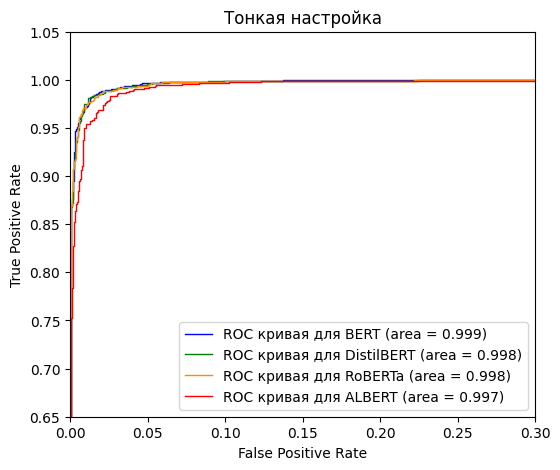

In [131]:
plt.figure(figsize=(6,5))
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.plot(BERT_fpr, BERT_tpr, linewidth=1, color='blue', label='ROC кривая для BERT (area = %0.3f)' % BERT_roc_auc)
plt.plot(DistilBERT_fpr, DistilBERT_tpr, linewidth=1, color='green', label='ROC кривая для DistilBERT (area = %0.3f)' % DistilBERT_roc_auc)
plt.plot(RoBERTa_fpr, RoBERTa_tpr, linewidth=1, color='darkorange', label='ROC кривая для RoBERTa (area = %0.3f)' % RoBERTa_roc_auc)
plt.plot(ALBERT_fpr, ALBERT_tpr, linewidth=1, color='red', label='ROC кривая для ALBERT (area = %0.3f)' % ALBERT_roc_auc)
plt.xlim([0.0, 0.3])
plt.ylim([0.65, 1.05])
plt.title('Тонкая настройка')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

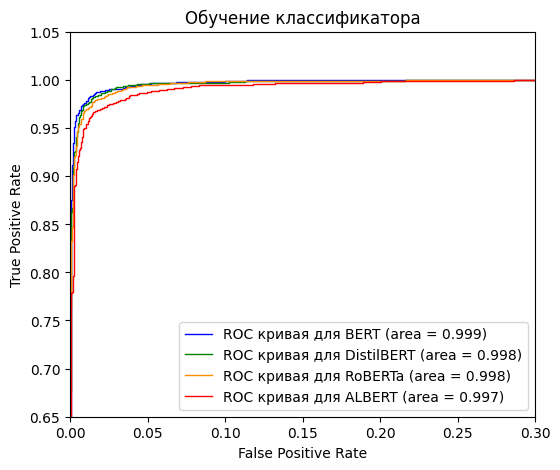

In [132]:
plt.figure(figsize=(6,5))
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.plot(BERT_freezed_fpr, BERT_freezed_tpr, linewidth=1, color='blue', label='ROC кривая для BERT (area = %0.3f)' % BERT_freezed_roc_auc)
plt.plot(DistilBERT_freezed_fpr, DistilBERT_freezed_tpr, linewidth=1, color='green', label='ROC кривая для DistilBERT (area = %0.3f)' % DistilBERT_freezed_roc_auc)
plt.plot(RoBERTa_freezed_fpr, RoBERTa_freezed_tpr, linewidth=1, color='darkorange', label='ROC кривая для RoBERTa (area = %0.3f)' % RoBERTa_freezed_roc_auc)
plt.plot(ALBERT_freezed_fpr, ALBERT_freezed_tpr, linewidth=1, color='red', label='ROC кривая для ALBERT (area = %0.3f)' % ALBERT_freezed_roc_auc)
plt.xlim([0.0, 0.3])
plt.ylim([0.65, 1.05])
plt.title('Обучение классификатора')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [133]:
BERT_test_fpr, BERT_test_tpr, _ = roc_curve(y_test, BERT_test_predict)
BERT_freezed_test_fpr, BERT_freezed_test_tpr, _ = roc_curve(y_test, BERT_freezed_test_predict)
DistilBERT_test_fpr, DistilBERT_test_tpr, _ = roc_curve(y_test, DistilBERT_test_predict)
DistilBERT_freezed_test_fpr, DistilBERT_freezed_test_tpr, _ = roc_curve(y_test, DistilBERT_freezed_test_predict)
RoBERTa_test_fpr, RoBERTa_test_tpr, _ = roc_curve(y_test, RoBERTa_test_predict)
RoBERTa_freezed_test_fpr, RoBERTa_freezed_test_tpr, _ = roc_curve(y_test, RoBERTa_freezed_test_predict)
ALBERT_test_fpr, ALBERT_test_tpr, _ = roc_curve(y_test, ALBERT_test_predict)
ALBERT_freezed_test_fpr, ALBERT_freezed_test_tpr, _ = roc_curve(y_test, ALBERT_freezed_test_predict)

In [134]:
# np.save('/content/drive/MyDrive/NPY/BERT/BERT_test_fpr.npy', BERT_test_fpr)
# np.save('/content/drive/MyDrive/NPY/BERT/BERT_test_tpr.npy', BERT_test_tpr)
# np.save('/content/drive/MyDrive/NPY/BERT/BERT_freezed_test_fpr.npy', BERT_freezed_test_fpr)
# np.save('/content/drive/MyDrive/NPY/BERT/BERT_freezed_test_tpr.npy', BERT_freezed_test_tpr)

# np.save('/content/drive/MyDrive/NPY/DistilBERT/DistilBERT_test_fpr.npy', DistilBERT_test_fpr)
# np.save('/content/drive/MyDrive/NPY/DistilBERT/DistilBERT_test_tpr.npy', DistilBERT_test_tpr)
# np.save('/content/drive/MyDrive/NPY/DistilBERT/DistilBERT_freezed_test_fpr.npy', DistilBERT_freezed_test_fpr)
# np.save('/content/drive/MyDrive/NPY/DistilBERT/DistilBERT_freezed_test_tpr.npy', DistilBERT_freezed_test_tpr)

# np.save('/content/drive/MyDrive/NPY/RoBERTa/RoBERTa_test_fpr.npy', RoBERTa_test_fpr)
# np.save('/content/drive/MyDrive/NPY/RoBERTa/RoBERTa_test_tpr.npy', RoBERTa_test_tpr)
# np.save('/content/drive/MyDrive/NPY/RoBERTa/RoBERTa_freezed_test_fpr.npy', RoBERTa_freezed_test_fpr)
# np.save('/content/drive/MyDrive/NPY/RoBERTa/RoBERTa_freezed_test_tpr.npy', RoBERTa_freezed_test_tpr)

# np.save('/content/drive/MyDrive/NPY/ALBERT/ALBERT_test_fpr.npy', ALBERT_test_fpr)
# np.save('/content/drive/MyDrive/NPY/ALBERT/ALBERT_test_tpr.npy', ALBERT_test_tpr)
# np.save('/content/drive/MyDrive/NPY/ALBERT/ALBERT_freezed_test_fpr.npy', ALBERT_freezed_test_fpr)
# np.save('/content/drive/MyDrive/NPY/ALBERT/ALBERT_freezed_test_tpr.npy', ALBERT_freezed_test_tpr)

In [135]:
BERT_test_roc_auc = roc_auc_score(y_test, BERT_test_predict)
BERT_freezed_test_roc_auc = roc_auc_score(y_test, BERT_freezed_test_predict)
DistilBERT_test_roc_auc = roc_auc_score(y_test, DistilBERT_test_predict)
DistilBERT_freezed_test_roc_auc = roc_auc_score(y_test, DistilBERT_freezed_test_predict)
RoBERTa_test_roc_auc = roc_auc_score(y_test, RoBERTa_test_predict)
RoBERTa_freezed_test_roc_auc = roc_auc_score(y_test, RoBERTa_freezed_test_predict)
ALBERT_test_roc_auc = roc_auc_score(y_test, ALBERT_test_predict)
ALBERT_freezed_test_roc_auc = roc_auc_score(y_test, ALBERT_freezed_test_predict)

### Другой датасет

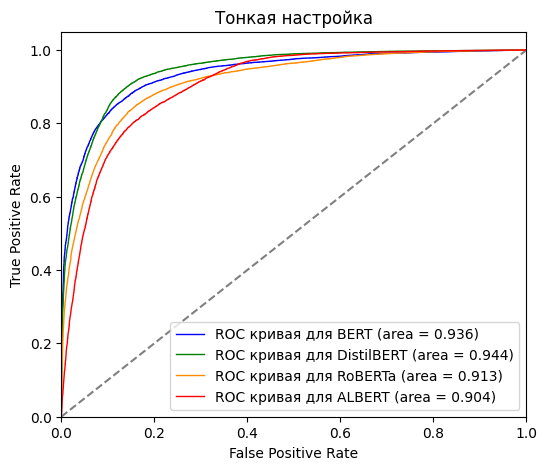

In [136]:
plt.figure(figsize=(6,5))
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.plot(BERT_test_fpr, BERT_test_tpr, linewidth=1, color='blue', label='ROC кривая для BERT (area = %0.3f)' % BERT_test_roc_auc)
plt.plot(DistilBERT_test_fpr, DistilBERT_test_tpr, linewidth=1, color='green', label='ROC кривая для DistilBERT (area = %0.3f)' % DistilBERT_test_roc_auc)
plt.plot(RoBERTa_test_fpr, RoBERTa_test_tpr, linewidth=1, color='darkorange', label='ROC кривая для RoBERTa (area = %0.3f)' % RoBERTa_test_roc_auc)
plt.plot(ALBERT_test_fpr, ALBERT_test_tpr, linewidth=1, color='red', label='ROC кривая для ALBERT (area = %0.3f)' % ALBERT_test_roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Тонкая настройка')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

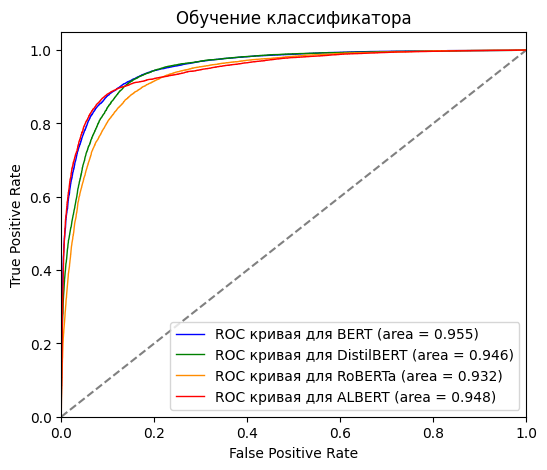

In [137]:
plt.figure(figsize=(6,5))
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.plot(BERT_freezed_test_fpr, BERT_freezed_test_tpr, linewidth=1, color='blue', label='ROC кривая для BERT (area = %0.3f)' % BERT_freezed_test_roc_auc)
plt.plot(DistilBERT_freezed_test_fpr, DistilBERT_freezed_test_tpr, linewidth=1, color='green', label='ROC кривая для DistilBERT (area = %0.3f)' % DistilBERT_freezed_test_roc_auc)
plt.plot(RoBERTa_freezed_test_fpr, RoBERTa_freezed_test_tpr, linewidth=1, color='darkorange', label='ROC кривая для RoBERTa (area = %0.3f)' % RoBERTa_freezed_test_roc_auc)
plt.plot(ALBERT_freezed_test_fpr, ALBERT_freezed_test_tpr, linewidth=1, color='red', label='ROC кривая для ALBERT (area = %0.3f)' % ALBERT_freezed_test_roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Обучение классификатора')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()